# Bank Marketing Campaign Classification

This notebook builds a classification pipeline to predict whether a customer will subscribe to a term deposit based on the UCI Bank Marketing dataset.

## Imports

In [1]:
# Standard library
from pathlib import Path
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Scikit-learn: preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model interpretability
import shap

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

Configure project paths and load the Bank Marketing dataset.

In [2]:
# Resolve project paths
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

# Define directory structure
DATA_DIR = PROJECT_ROOT / "datasets" / "bank-marketing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"

# Create output directories
for path in [PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")

Project root: /home/ermaolaoye/data-mining
Outputs directory: /home/ermaolaoye/data-mining/outputs


In [3]:
# Load dataset
data_path = DATA_DIR / "bank-full.csv"
df_raw = pd.read_csv(data_path, sep=";")

print(f"Loaded {df_raw.shape[0]:,} rows and {df_raw.shape[1]} columns")
print(f"\nTarget distribution:")
print(df_raw["y"].value_counts(normalize=True).rename("proportion").to_string())
print(f"\nClass imbalance ratio: {df_raw['y'].value_counts()['no'] / df_raw['y'].value_counts()['yes']:.2f}:1")

Loaded 45,211 rows and 17 columns

Target distribution:
y
no     0.883015
yes    0.116985

Class imbalance ratio: 7.55:1


## Preprocessing

### Outlier Removal
Remove extreme outliers (z-score > 3) from numeric columns to reduce noise.

In [4]:
# Remove outliers using z-score method
# Keeps more edge cases that may contain valuable signal
df = df_raw.copy()
outlier_cols = ["balance", "age", "campaign"]

# Drop duration column - it's only known after a call ends (data leakage)
df = df.drop(columns=["duration"])

# Create a combined mask for all outlier conditions (relaxed threshold)
outlier_mask = pd.Series(True, index=df.index)
for col in outlier_cols:
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    outlier_mask &= (z_scores < 4)  # Changed from 3 to 4 (less aggressive)

df = df[outlier_mask].reset_index(drop=True)

print(f"Rows before: {df_raw.shape[0]:,}")
print(f"Rows after outlier removal: {df.shape[0]:,}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]:,} ({100 * (1 - df.shape[0] / df_raw.shape[0]):.1f}%)")
print(f"\nNote: 'duration' column dropped (only known post-call, causes data leakage)")

Rows before: 45,211
Rows after outlier removal: 44,220
Rows removed: 991 (2.2%)

Note: 'duration' column dropped (only known post-call, causes data leakage)


In [5]:
# Separate features and target
X = df.drop(columns="y")
y = df["y"].map({"yes": 1, "no": 0})

# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric features (6): ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']


## Feature Engineering

Create domain-specific features to improve model predictive power.

**Note**: The `duration` feature was removed from the dataset as it represents call duration, which is only known after a call ends and would cause data leakage in a real prediction scenario.

In [6]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # -1 means never contacted, don't use 999 which creates outliers
    df["was_contacted_before"] = (df["pdays"] != -1).astype(int)
    
    # For those contacted before, use log transform (adds 1 to avoid log(0))
    # For never contacted, use median of contacted group
    contacted_mask = df["pdays"] != -1
    if contacted_mask.sum() > 0:
        median_pdays = df.loc[contacted_mask, "pdays"].median()
        df["pdays_transformed"] = df["pdays"].replace(-1, median_pdays)
        df["pdays_log"] = np.log1p(df["pdays_transformed"])
    else:
        df["pdays_log"] = 0
    
    # Recency buckets, more informative than raw days
    df["contact_recency"] = pd.cut(
        df["pdays"].replace(-1, 9999),
        bins=[-1, 7, 30, 90, 180, 365, 10000],
        labels=["week", "month", "quarter", "half_year", "year", "never"]
    ).astype(str)
    
    # Previous campaign success is extremely predictive (~65% conversion if success)
    df["prev_success"] = (df["poutcome"] == "success").astype(int)
    df["prev_failure"] = (df["poutcome"] == "failure").astype(int)
    df["prev_unknown"] = (df["poutcome"] == "unknown").astype(int)
    
    # Interaction: contacted before AND had success
    df["contacted_and_success"] = (df["was_contacted_before"] & df["prev_success"]).astype(int)
    
    # === Contact history features ===
    df["contact_intensity"] = df["campaign"] / (df["previous"] + 1)
    df["total_contacts"] = df["campaign"] + df["previous"]
    df["high_campaign_effort"] = (df["campaign"] > df["campaign"].median()).astype(int)
    
    # === Financial features ===
    df["balance_per_age"] = df["balance"] / (df["age"] + 1)
    df["has_positive_balance"] = (df["balance"] > 0).astype(int)
    df["has_high_balance"] = (df["balance"] > df["balance"].quantile(0.75)).astype(int)
    df["has_loan_or_default"] = ((df["loan"] == "yes") | (df["default"] == "yes")).astype(int)
    
    # === Demographic interactions ===
    df["young_single"] = ((df["age"] < 30) & (df["marital"] == "single")).astype(int)
    df["retired_age"] = (df["age"] >= 60).astype(int)
    
    # === Time-based features ===
    if "day" in df.columns:
        df["is_month_start"] = (df["day"] <= 10).astype(int)
        df["is_month_end"] = (df["day"] >= 20).astype(int)
    
    # Month seasonality (certain months have higher conversion)
    high_conversion_months = ["mar", "oct", "sep", "dec"]
    df["is_high_conversion_month"] = df["month"].isin(high_conversion_months).astype(int)
    
    # Drop intermediate columns
    df = df.drop(columns=["pdays_transformed"], errors="ignore")
    
    return df


# Apply feature engineering
X_engineered = engineer_features(X)

new_features = set(X_engineered.columns) - set(X.columns)
print(f"Original features: {len(X.columns)}")
print(f"Engineered features: {len(X_engineered.columns)}")
print(f"New features added ({len(new_features)}): {sorted(new_features)}")

Original features: 15
Engineered features: 34
New features added (19): ['balance_per_age', 'contact_intensity', 'contact_recency', 'contacted_and_success', 'has_high_balance', 'has_loan_or_default', 'has_positive_balance', 'high_campaign_effort', 'is_high_conversion_month', 'is_month_end', 'is_month_start', 'pdays_log', 'prev_failure', 'prev_success', 'prev_unknown', 'retired_age', 'total_contacts', 'was_contacted_before', 'young_single']


In [7]:
# Update column lists for engineered features
categorical_cols_eng = X_engineered.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols_eng = X_engineered.select_dtypes(include=["number"]).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_eng),
        ("num", StandardScaler(), numeric_cols_eng),
    ]
)

print(f"Categorical features: {len(categorical_cols_eng)}")
print(f"Numeric features: {len(numeric_cols_eng)}")

Categorical features: 10
Numeric features: 24


### Train/Test Split

Use stratified split to preserve class distribution in both sets.

In [8]:
# Stratified train/validation/test split
# First split: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: train vs validation (75/25 of remaining = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Calculate class weight for imbalanced learning
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape[0]:,} samples (60%)")
print(f"Validation set: {X_val.shape[0]:,} samples (20%) - for early stopping")
print(f"Test set: {X_test.shape[0]:,} samples (20%)")
print(f"Positive class weight: {pos_weight:.2f}")
print(f"\nTrain class distribution:")
print(y_train.value_counts(normalize=True).rename({0: "no", 1: "yes"}).to_string())

Training set: 26,532 samples (60%)
Validation set: 8,844 samples (20%) - for early stopping
Test set: 8,844 samples (20%)
Positive class weight: 7.50

Train class distribution:
y
no     0.882331
yes    0.117669


### Helper Functions

Utility functions for threshold optimization and model evaluation.

In [9]:
def find_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray) -> tuple[float, float]:
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find best threshold (precision_recall_curve returns n+1 values, last has no threshold)
    best_idx = np.argmax(f1_scores[:-1])
    return thresholds[best_idx], f1_scores[best_idx]


def evaluate_model(
    name: str, 
    y_true: np.ndarray, 
    y_proba: np.ndarray, 
    threshold: float = None
) -> dict:
    if threshold is None:
        threshold, _ = find_optimal_threshold(y_true, y_proba)
    
    y_pred = (y_proba >= threshold).astype(int)
    
    metrics = {
        "name": name,
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "predictions": y_pred,
        "probabilities": y_proba,
    }
    
    print(f"\n{'='*50}")
    print(f"{name} @ threshold {threshold:.3f}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

## Model Training

Train multiple classifiers with different approaches to handle class imbalance:
1. **Class weights**: Built-in parameter to penalize misclassification of minority class
2. **SMOTE**: Synthetic Minority Over-sampling Technique to balance training data

In [10]:
# Store all results for comparison
all_results = []

### Manually implementation: Classification Tree

In [11]:
import DecisionTree as dt 
from tqdm import tqdm

# find the best model
# max_depth_list = range(5,21,2)
# min_sample_list = range(5,21)
# best_evaluation_loss = 1e4
# best_max_depth = 0
# best_min_sample = 0
# best_preds = np.full_like(y_test,0.0,dtype=float)
# best_tree = None

# total_combinations = len(max_depth_list) * len(min_sample_list)
# with tqdm(total=total_combinations, desc="Grid Search", unit="models") as pbar:
#     for max_depth in max_depth_list:
#         for min_sample in min_sample_list:
#             pbar.set_postfix(max_depth=max_depth, min_sample=min_sample)
#             clstree = dt.ClassificationTree(loss_function="Entropy", leaf_value_estimator="most_common_vote", max_depth=max_depth, min_sample=min_sample)
#             clstree.fit(X_train, y_train)
#             clstree.prune(X_val, y_val)
#             y_preds = clstree.predict_batch(X_test)
#             current_evaluation_loss = np.sum(y_preds != y_test)
#             if current_evaluation_loss < best_evaluation_loss:
#                 best_evaluation_loss = current_evaluation_loss
#                 best_max_depth = max_depth 
#                 best_min_sample = min_sample
#                 best_preds = y_preds
#                 best_tree = clstree
#             pbar.update(1)

# print(f"\nBest parameters: max_depth={best_max_depth}, min_sample={best_min_sample}")
# print(f"Best evaluation loss: {best_evaluation_loss}")

In [12]:
# clstree.prune(X_val,y_val)

In [13]:
# y_preds = clstree.predict_batch(X_test)
# evaluate_model("Classificationtree", y_test, y_preds)

### XGBoost with SMOTE

In [14]:
# XGBoost with SMOTE and early stopping

preprocessor_fitted = clone(preprocessor).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_val_transformed = preprocessor_fitted.transform(X_val)
X_test_transformed = preprocessor_fitted.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print(f"Training samples before SMOTE: {X_train_transformed.shape[0]:,}")
print(f"Training samples after SMOTE: {X_train_smote.shape[0]:,}")

xgb_model = XGBClassifier(
    n_estimators=1000,  # High value, early stopping will find optimal
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.15,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective="binary:logistic",
    eval_metric="auc",  # Use AUC for imbalanced data
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=50,
)

xgb_model.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_val_transformed, y_val)],
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")

# Wrapper pipeline for consistency
class XGBSMOTEWrapper:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
    
    def predict_proba(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict_proba(X_transformed)
    
    def predict(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict(X_transformed)

xgb_smote_pipeline = XGBSMOTEWrapper(preprocessor_fitted, xgb_model)

# Evaluate
xgb_smote_proba = xgb_smote_pipeline.predict_proba(X_test)[:, 1]
xgb_smote_results = evaluate_model("XGBoost + SMOTE", y_test, xgb_smote_proba)
all_results.append(xgb_smote_results)

Training samples before SMOTE: 26,532
Training samples after SMOTE: 46,820
Best iteration: 673

XGBoost + SMOTE @ threshold 0.311
  Accuracy:  0.8805
  Precision: 0.4920
  Recall:    0.4736
  F1 Score:  0.4826
  ROC AUC:   0.7975


### Manually implementation: Classification Tree with SMOTE

In [15]:
import DecisionTree as dt
from tqdm import tqdm

# find the best model
max_depth_list = [5,10,15,20]
min_sample_list = [5,10,15,20]
loss_list = ["Entropy", "Gini"]
best_evaluation_loss = float("inf")
best_max_depth = 0
best_min_sample = 0
best_lossfunc = None
best_tree = None

total_combinations = len(max_depth_list) * len(min_sample_list) * len(loss_list)
with tqdm(total=total_combinations, desc="Grid Search", unit="models") as pbar:
    for max_depth in max_depth_list:
        for min_sample in min_sample_list:
            for loss_function_name in loss_list:
                pbar.set_postfix(max_depth=max_depth, min_sample=min_sample)
                clstree = dt.ClassificationTree(loss_function=loss_function_name, leaf_value_estimator="most_common_vote", max_depth=max_depth, min_sample=min_sample)
                clstree.fit(X_train_smote, y_train_smote)
                clstree.prune(X_val_transformed, y_val)
                y_preds = clstree.predict(X_val_transformed)
                current_evaluation_loss = np.sum(y_preds != y_val)
                if current_evaluation_loss < best_evaluation_loss:
                    best_evaluation_loss = current_evaluation_loss
                    best_max_depth = max_depth 
                    best_min_sample = min_sample
                    best_lossfunc = loss_function_name
                    best_tree = clstree
                pbar.update(1)


print(f"\nBest parameters: max_depth={best_max_depth}, min_sample={best_min_sample}, loss_function = {best_lossfunc}")

Grid Search: 100%|██████████| 32/32 [00:40<00:00,  1.28s/models, max_depth=20, min_sample=20]


Best parameters: max_depth=20, min_sample=5, loss_function = Gini


In [16]:
# evaluation on test set
tree_preds = best_tree.predict(X_test_transformed)
evaluate_model("Classificationtree", y_test, tree_preds)
all_results.append(tree_preds)


Classificationtree @ threshold 1.000
  Accuracy:  0.8860
  Precision: 0.5267
  Recall:    0.3132
  F1 Score:  0.3928
  ROC AUC:   0.6378


In [17]:
# XGBoost with class weights (scale_pos_weight)
xgb_weighted_pipeline = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("classifier", XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.15,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        scale_pos_weight=pos_weight,
        tree_method="hist",
    )),
])

xgb_weighted_pipeline.fit(X_train, y_train)
xgb_weighted_proba = xgb_weighted_pipeline.predict_proba(X_test)[:, 1]
xgb_weighted_results = evaluate_model("XGBoost (weighted)", y_test, xgb_weighted_proba)
all_results.append(xgb_weighted_results)


XGBoost (weighted) @ threshold 0.613
  Accuracy:  0.8727
  Precision: 0.4645
  Recall:    0.5341
  F1 Score:  0.4969
  ROC AUC:   0.8027


## Bayesian Hyperparameter Optimization

Use `BayesSearchCV` from scikit-optimize to find optimal hyperparameters for each model. Bayesian optimization is more efficient than grid search as it uses past evaluation results to choose the next hyperparameters to evaluate.

In [18]:
# Bayesian Optimization imports
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Use stratified k-fold for imbalanced data
bayes_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# SMOTE for handling class imbalance (applied only during training in CV)
smote = SMOTE(random_state=RANDOM_STATE)

# Store Bayesian optimization results
bayes_results = {}

### XGBoost Bayesian Optimization

In [19]:
# XGBoost Bayesian Search with SMOTE
xgb_search_spaces = {
    'classifier__n_estimators': Integer(100, 1000),
    'classifier__max_depth': Integer(3, 10),
    'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'classifier__subsample': Real(0.6, 1.0),
    'classifier__colsample_bytree': Real(0.6, 1.0),
    'classifier__gamma': Real(0, 5),
    'classifier__min_child_weight': Integer(1, 10),
    'classifier__reg_alpha': Real(1e-8, 10.0, prior='log-uniform'),
    'classifier__reg_lambda': Real(1e-8, 10.0, prior='log-uniform'),
}

xgb_base_model = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
)

# Create pipeline with SMOTE and XGBoost
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', xgb_base_model)
])

xgb_bayes_search = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=xgb_search_spaces,
    n_iter=50,  # Number of parameter settings to try
    cv=bayes_cv,
    scoring='roc_auc',  # Use ROC-AUC for imbalanced data
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)

print("Starting XGBoost Bayesian Optimization with SMOTE...")
xgb_bayes_search.fit(X_train_transformed, y_train)

bayes_results['XGBoost'] = {
    'best_params': xgb_bayes_search.best_params_,
    'best_score': xgb_bayes_search.best_score_,
    'best_estimator': xgb_bayes_search.best_estimator_,
}

print("\n" + "=" * 60)
print("XGBoost Bayesian Optimization Results")
print("=" * 60)
print(f"Best parameters: {xgb_bayes_search.best_params_}")
print(f"Best CV ROC-AUC: {xgb_bayes_search.best_score_:.4f}")

Starting XGBoost Bayesian Optimization with SMOTE...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fit

### Bayesian Optimization Summary & Evaluation

In [20]:
# Summary of Bayesian Optimization Results
print("=" * 80)
print("BAYESIAN OPTIMIZATION SUMMARY")
print("=" * 80)

bayes_summary = []
for model_name, results in bayes_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV ROC-AUC: {results['best_score']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")
    bayes_summary.append({
        'Model': model_name,
        'Best CV ROC-AUC': results['best_score'],
    })

bayes_summary_df = pd.DataFrame(bayes_summary).sort_values('Best CV ROC-AUC', ascending=False)
print("\n" + "=" * 80)
print("MODEL RANKING BY CV ROC-AUC:")
print("=" * 80)
print(bayes_summary_df.to_string(index=False))

BAYESIAN OPTIMIZATION SUMMARY

XGBoost:
  Best CV ROC-AUC: 0.7943
  Best Parameters: OrderedDict({'classifier__colsample_bytree': 0.6, 'classifier__gamma': 2.3127483103583395, 'classifier__learning_rate': 0.014235661651117485, 'classifier__max_depth': 8, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 677, 'classifier__reg_alpha': 1.3222952747135129e-08, 'classifier__reg_lambda': 1.4990632767623027e-06, 'classifier__subsample': 0.6053838410694129})

MODEL RANKING BY CV ROC-AUC:
  Model  Best CV ROC-AUC
XGBoost         0.794278


In [21]:
# Evaluate tuned models on test set
bayes_tuned_results = []

print("\n" + "=" * 80)
print("EVALUATING BAYESIAN-TUNED MODELS ON TEST SET")
print("=" * 80)

for model_name, results in bayes_results.items():
    best_model = results['best_estimator']
    
    # Get predictions
    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    
    # Evaluate
    tuned_results = evaluate_model(f"{model_name} (Bayes-tuned)", y_test, y_proba)
    bayes_tuned_results.append(tuned_results)

# Add to main results list for comparison
all_results.extend(bayes_tuned_results)


EVALUATING BAYESIAN-TUNED MODELS ON TEST SET

XGBoost (Bayes-tuned) @ threshold 0.288
  Accuracy:  0.8728
  Precision: 0.4629
  Recall:    0.5034
  F1 Score:  0.4823
  ROC AUC:   0.7982


In [22]:
# Compare tuned vs untuned models
tuned_comparison = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ["predictions", "probabilities"]}
    for r in bayes_tuned_results
]).sort_values("f1", ascending=False)

print("\n" + "=" * 80)
print("BAYESIAN-TUNED MODELS COMPARISON (sorted by F1 score)")
print("=" * 80)
print(tuned_comparison.to_string(index=False))

# Find best tuned model
best_tuned_model = tuned_comparison.iloc[0]["name"]
best_tuned_f1 = tuned_comparison.iloc[0]["f1"]
print(f"\nBest Bayesian-tuned model: {best_tuned_model} (F1 = {best_tuned_f1:.4f})")


BAYESIAN-TUNED MODELS COMPARISON (sorted by F1 score)
                 name  threshold  accuracy  precision   recall       f1  roc_auc
XGBoost (Bayes-tuned)    0.28793  0.872795   0.462898 0.503362 0.482283  0.79816

Best Bayesian-tuned model: XGBoost (Bayes-tuned) (F1 = 0.4823)


### Reactive Rule Learner (RRL)

RRL is an interpretable rule-based model that learns logical rules from data. It provides transparent decision-making through human-readable rules.

In [24]:

# RRL Training using preprocessed and engineered features with hyperparameter search
import torch
from torch.utils.data import DataLoader, TensorDataset
import importlib
import rrl.models
from rrl.models import RRL
from rrl.utils import DBEncoder
from itertools import product

# Set device for RRL
rrl_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.backends.mps.is_available():
        rrl_device = torch.device("mps")
except:
    pass
print(f"Using device for RRL: {rrl_device}", flush=True)

# Use engineered features (same as other models)
# Create feature info dataframe for DBEncoder from X_engineered
print("Preparing engineered features for RRL...", flush=True)
f_list = []
for col in X_engineered.columns:
    if X_engineered[col].dtype == 'object':
        f_list.append([col, 'discrete'])
    else:
        f_list.append([col, 'continuous'])

f_df = pd.DataFrame(f_list)

# Initialize DBEncoder with engineered features
db_enc = DBEncoder(f_df, discrete=False)

# Create target dataframe (DBEncoder expects DataFrame)
y_train_df = y_train.to_frame(name='y')
y_val_df = y_val.to_frame(name='y')
y_test_df = y_test.to_frame(name='y')

# Fit encoder on training data
db_enc.fit(X_train, y_train_df)

# Transform all splits
X_rrl_train, y_rrl_train = db_enc.transform(X_train, y_train_df, normalized=True, keep_stat=True)
X_rrl_val, y_rrl_val = db_enc.transform(X_val, y_val_df, normalized=True, keep_stat=False)
X_rrl_test, y_rrl_test = db_enc.transform(X_test, y_test_df, normalized=True, keep_stat=False)

print(f"RRL Training samples: {X_rrl_train.shape[0]:,}", flush=True)
print(f"RRL Validation samples: {X_rrl_val.shape[0]:,}", flush=True)
print(f"RRL Test samples: {X_rrl_test.shape[0]:,}", flush=True)

# Create DataLoaders with optimized settings for speed
print("Creating tensors...", flush=True)
rrl_batch_size = 256

# FIX: Explicitly convert to float32 numpy arrays before creating tensors
# DBEncoder.transform can return object dtype arrays which cause torch.tensor() to hang
X_rrl_train = np.asarray(X_rrl_train, dtype=np.float32)
X_rrl_val = np.asarray(X_rrl_val, dtype=np.float32)
X_rrl_test = np.asarray(X_rrl_test, dtype=np.float32)
y_rrl_train = np.asarray(y_rrl_train, dtype=np.float32)
y_rrl_val = np.asarray(y_rrl_val, dtype=np.float32)
y_rrl_test = np.asarray(y_rrl_test, dtype=np.float32)

# Create tensors using torch.from_numpy (faster than torch.tensor for contiguous arrays)
X_train_tensor = torch.from_numpy(X_rrl_train)
y_train_tensor = torch.from_numpy(y_rrl_train)
X_val_tensor = torch.from_numpy(X_rrl_val)
y_val_tensor = torch.from_numpy(y_rrl_val)
X_test_tensor = torch.from_numpy(X_rrl_test)
y_test_tensor = torch.from_numpy(y_rrl_test)

rrl_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
rrl_val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
rrl_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

rrl_train_loader = DataLoader(rrl_train_dataset, batch_size=rrl_batch_size, shuffle=True)
rrl_val_loader = DataLoader(rrl_val_dataset, batch_size=rrl_batch_size, shuffle=False)
rrl_test_loader = DataLoader(rrl_test_dataset, batch_size=rrl_batch_size, shuffle=False)

discrete_flen = db_enc.discrete_flen
continuous_flen = db_enc.continuous_flen
rrl_output_dim = y_rrl_train.shape[1]  # One-hot encoded length

print(f"Discrete features: {discrete_flen}, Continuous features: {continuous_flen}", flush=True)
print(f"RRL output dimension: {rrl_output_dim}", flush=True)

# Hyperparameter search space (patterned after Housing_RRL)
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'temperature': [0.05, 0.1, 0.2],
    'structure': [[16, 16, 8], [32, 32, 16], [64, 32, 16]]
}

best_val_f1 = -float('inf')
best_params = None
best_model_state = None
best_dim_list = None
rrl_search_results = []

print("Starting hyperparameter search...", flush=True)
print("=" * 60, flush=True)
all_combos = list(product(param_grid['lr'], param_grid['temperature'], param_grid['structure']))
print(f"Testing {len(all_combos)} configurations\n", flush=True)

for i, (lr, temp, struct) in enumerate(all_combos, start=1):
    current_dim_list = [(discrete_flen, continuous_flen)] + list(struct) + [rrl_output_dim]

    candidate_model = RRL(
        dim_list=current_dim_list,
        device=rrl_device,
        use_not=True,
        is_rank0=True,
        save_best=False,
        distributed=False,
        use_skip=False,
        save_path=MODELS_DIR / "rrl_search_tmp.pth",
        temperature=temp
    )

    # Train (fewer epochs for search)
    candidate_model.train_model(
        data_loader=rrl_train_loader,
        valid_loader=rrl_val_loader,
        epoch=30,
        lr=lr,
        weight_decay=1e-5,
        show_progress=False
    )

    # Evaluate on validation set
    _, val_f1 = candidate_model.test(
        test_loader=rrl_val_loader,
        set_name='Validation',
        show_progress=False
    )

    rrl_search_results.append({
        "lr": lr,
        "temperature": temp,
        "structure": list(struct),
        "val_f1": val_f1,
    })

    print(f"[{i}/{len(all_combos)}] lr={lr}, temp={temp}, struct={struct} -> Val F1: {val_f1:.4f}", flush=True)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_params = {'lr': lr, 'temperature': temp, 'structure': list(struct)}
        best_dim_list = current_dim_list
        best_model_state = {k: v.detach().cpu() for k, v in candidate_model.net.state_dict().items()}

if best_model_state is None:
        raise RuntimeError("Hyperparameter search did not produce a valid model.")

print("" + "=" * 60, flush=True)
print(f"Best parameters: {best_params}")
print(f"Best validation F1: {best_val_f1:.4f}")
print("=" * 60, flush=True)

search_results_df = pd.DataFrame(rrl_search_results).sort_values('val_f1', ascending=False)
print("RRL search leaderboard (sorted by validation F1):", search_results_df.to_string(index=False))

rrl_model_path = MODELS_DIR / 'rrl_bank_model.pth'
rrl_log_path = MODELS_DIR / 'rrl_bank_log.txt'
rrl_rules_path = MODELS_DIR / 'rrl_bank_rules.txt'

# Rebuild best model and save checkpoint
rrl_model = RRL(
    dim_list=best_dim_list,
    device=rrl_device,
    use_not=True,
    is_rank0=True,
    distributed=False,
    save_best=False,
    use_skip=False,
    temperature=best_params['temperature']
)
rrl_model.net.load_state_dict(best_model_state)
rrl_model.net.eval()

best_rrl_args = {
    'dim_list': best_dim_list,
    'use_not': True,
    'use_skip': False,
    'estimated_grad': False,
    'use_nlaf': False,
    'alpha': 0.999,
    'beta': 8,
    'gamma': 1,
    'temperature': best_params['temperature']
}

torch.save({'model_state_dict': best_model_state, 'rrl_args': best_rrl_args}, rrl_model_path)
print(f"Saved best RRL model to {rrl_model_path}", flush=True)

# Test best model
print("Testing best RRL model...", flush=True)
rrl_model.test(test_loader=rrl_test_loader, set_name='Test', show_progress=True)

# Print Rules
print("Generating rules...", flush=True)
with open(rrl_rules_path, 'w') as f:
    rrl_model.rule_print(db_enc.X_fname, db_enc.y_fname, rrl_train_loader, file=f, mean=db_enc.mean, std=db_enc.std)

print(f"RRL Model saved to {rrl_model_path}", flush=True)
print(f"RRL Rules saved to {rrl_rules_path}", flush=True)


Using device for RRL: cuda
Preparing engineered features for RRL...
RRL Training samples: 26,532
RRL Validation samples: 8,844
RRL Test samples: 8,844
Creating tensors...
Discrete features: 40, Continuous features: 24
RRL output dimension: 2
Starting hyperparameter search...
Testing 27 configurations



/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


2025-12-31 01:55:24,743 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 01:55:24,794 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 01:55:24,795 - [DEBUG] - y_rrl: (8844, 2) [[-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 ]
 [-0.28300145 -0.3419004 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:55:25,121 - [INFO] - epoch: 0, loss_rrl: 39.866125613451004
2025-12-31 01:55:25,404 - [INFO] - epoch: 1, loss_rrl: 38.7901996076107
2025-12-31 01:55:25,681 - [INFO] - epoch: 2, loss_rrl: 38.32951134443283
2025-12-31 01:55:25,968 - [INFO] - epoch: 3, loss_rrl: 38.00548055768013
2025-12-31 01:55:26,267 - [INFO] - epoch: 4, loss_rrl: 38.04019036889076
2025-12-31 01:55:26,596 - [INFO] - epoch: 5, loss_rrl: 37.92647576332092
2025-12-31 01:55:26,974 - [INFO] - epoch: 6, loss_rrl: 37.90866497159004
2025-12-31 01:55:27,304 - [INFO] - epoch: 7, loss_rrl: 39.692096412181854
2025-12-31 01:55:27,608 - [INFO] - epoch: 8, loss_rrl: 37.91069416701794
2025-12-31 01:55:28,145 - [INFO] - epoch: 9, loss_rrl: 36.322612911462784
2025-12-31 01:55:28,424 - [INFO] - epoch: 10, loss_rrl: 36.426009729504585
2025-12-31 01:55:28,692 - [INFO] - epoch: 11, loss_rrl: 36.58283621072769
2025-12-31 01:55:28,975 - [INFO] - epoch: 12, loss_rrl: 36.47950538992882
2025-12-31 01:55:29,272 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:55:34,799 - [INFO] - epoch: 0, loss_rrl: 94.81116768717766
2025-12-31 01:55:35,438 - [INFO] - epoch: 1, loss_rrl: 43.38159102201462
2025-12-31 01:55:36,026 - [INFO] - epoch: 2, loss_rrl: 43.71361583471298
2025-12-31 01:55:36,614 - [INFO] - epoch: 3, loss_rrl: 38.74358484148979
2025-12-31 01:55:37,202 - [INFO] - epoch: 4, loss_rrl: 38.6789842993021
2025-12-31 01:55:37,788 - [INFO] - epoch: 5, loss_rrl: 39.96998932957649
2025-12-31 01:55:38,375 - [INFO] - epoch: 6, loss_rrl: 37.995161563158035
2025-12-31 01:55:38,965 - [INFO] - epoch: 7, loss_rrl: 37.99665689468384
2025-12-31 01:55:39,548 - [INFO] - epoch: 8, loss_rrl: 37.98949319124222
2025-12-31 01:55:40,133 - [INFO] - epoch: 9, loss_rrl: 38.06693038344383
2025-12-31 01:55:40,736 - [INFO] - epoch: 10, loss_rrl: 40.624400064349174
2025-12-31 01:55:41,349 - [INFO] - epoch: 11, loss_rrl: 41.438333958387375
2025-12-31 01:55:41,955 - [INFO] - epoch: 12, loss_rrl: 41.31018480658531
2025-12-31 01:55:42,549 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:55:53,665 - [INFO] - epoch: 0, loss_rrl: 59.060353845357895
2025-12-31 01:55:54,681 - [INFO] - epoch: 1, loss_rrl: 52.733548045158386
2025-12-31 01:55:55,693 - [INFO] - epoch: 2, loss_rrl: 43.17850559949875
2025-12-31 01:55:56,928 - [INFO] - epoch: 3, loss_rrl: 39.46938472986221
2025-12-31 01:55:57,970 - [INFO] - epoch: 4, loss_rrl: 38.68158999085426
2025-12-31 01:55:59,005 - [INFO] - epoch: 5, loss_rrl: 38.19582411646843
2025-12-31 01:56:00,025 - [INFO] - epoch: 6, loss_rrl: 38.101768255233765
2025-12-31 01:56:01,062 - [INFO] - epoch: 7, loss_rrl: 37.999499559402466
2025-12-31 01:56:02,091 - [INFO] - epoch: 8, loss_rrl: 38.02936629951
2025-12-31 01:56:03,118 - [INFO] - epoch: 9, loss_rrl: 38.10683676600456
2025-12-31 01:56:04,154 - [INFO] - epoch: 10, loss_rrl: 38.105414003133774
2025-12-31 01:56:05,185 - [INFO] - epoch: 11, loss_rrl: 38.09729251265526
2025-12-31 01:56:06,199 - [INFO] - epoch: 12, loss_rrl: 38.06232985854149
2025-12-31 01:56:07,221 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:56:24,687 - [INFO] - epoch: 0, loss_rrl: 48.09136188030243
2025-12-31 01:56:25,034 - [INFO] - epoch: 1, loss_rrl: 38.64426216483116
2025-12-31 01:56:25,348 - [INFO] - epoch: 2, loss_rrl: 38.18620765209198
2025-12-31 01:56:25,643 - [INFO] - epoch: 3, loss_rrl: 38.0995571911335
2025-12-31 01:56:25,960 - [INFO] - epoch: 4, loss_rrl: 37.850241512060165
2025-12-31 01:56:26,230 - [INFO] - epoch: 5, loss_rrl: 37.86321344971657
2025-12-31 01:56:26,497 - [INFO] - epoch: 6, loss_rrl: 37.804613918066025
2025-12-31 01:56:26,764 - [INFO] - epoch: 7, loss_rrl: 37.82920598983765
2025-12-31 01:56:27,034 - [INFO] - epoch: 8, loss_rrl: 41.592833548784256
2025-12-31 01:56:27,304 - [INFO] - epoch: 9, loss_rrl: 37.7514024078846
2025-12-31 01:56:27,800 - [INFO] - epoch: 10, loss_rrl: 37.86166840791702
2025-12-31 01:56:28,067 - [INFO] - epoch: 11, loss_rrl: 37.91630932688713
2025-12-31 01:56:28,334 - [INFO] - epoch: 12, loss_rrl: 37.236790746450424
2025-12-31 01:56:28,614 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:56:34,523 - [INFO] - epoch: 0, loss_rrl: 53.72043350338936
2025-12-31 01:56:35,171 - [INFO] - epoch: 1, loss_rrl: 42.29754704236984
2025-12-31 01:56:35,779 - [INFO] - epoch: 2, loss_rrl: 39.94068622589111
2025-12-31 01:56:36,386 - [INFO] - epoch: 3, loss_rrl: 39.899364560842514
2025-12-31 01:56:37,004 - [INFO] - epoch: 4, loss_rrl: 41.091250121593475
2025-12-31 01:56:37,598 - [INFO] - epoch: 5, loss_rrl: 38.796768456697464
2025-12-31 01:56:38,208 - [INFO] - epoch: 6, loss_rrl: 37.90189963579178
2025-12-31 01:56:38,797 - [INFO] - epoch: 7, loss_rrl: 38.7674962580204
2025-12-31 01:56:39,387 - [INFO] - epoch: 8, loss_rrl: 39.03545859456062
2025-12-31 01:56:39,985 - [INFO] - epoch: 9, loss_rrl: 38.31723007559776
2025-12-31 01:56:40,600 - [INFO] - epoch: 10, loss_rrl: 37.86372631788254
2025-12-31 01:56:41,218 - [INFO] - epoch: 11, loss_rrl: 37.93606173992157
2025-12-31 01:56:41,841 - [INFO] - epoch: 12, loss_rrl: 37.92326292395592
2025-12-31 01:56:42,461 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:56:53,699 - [INFO] - epoch: 0, loss_rrl: 81.80350282788277
2025-12-31 01:56:54,732 - [INFO] - epoch: 1, loss_rrl: 46.95099180936813
2025-12-31 01:56:55,786 - [INFO] - epoch: 2, loss_rrl: 42.334869891405106
2025-12-31 01:56:57,022 - [INFO] - epoch: 3, loss_rrl: 40.03379359841347
2025-12-31 01:56:58,122 - [INFO] - epoch: 4, loss_rrl: 41.416403353214264
2025-12-31 01:56:59,168 - [INFO] - epoch: 5, loss_rrl: 39.20589888095856
2025-12-31 01:57:00,196 - [INFO] - epoch: 6, loss_rrl: 39.28189608454704
2025-12-31 01:57:01,232 - [INFO] - epoch: 7, loss_rrl: 38.315219938755035
2025-12-31 01:57:02,250 - [INFO] - epoch: 8, loss_rrl: 37.88213127851486
2025-12-31 01:57:03,283 - [INFO] - epoch: 9, loss_rrl: 38.512198597192764
2025-12-31 01:57:04,286 - [INFO] - epoch: 10, loss_rrl: 39.00547009706497
2025-12-31 01:57:05,316 - [INFO] - epoch: 11, loss_rrl: 37.899298429489136
2025-12-31 01:57:06,376 - [INFO] - epoch: 12, loss_rrl: 37.88870060443878
2025-12-31 01:57:07,406 - [INFO] - epoch: 1

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:57:24,641 - [INFO] - epoch: 0, loss_rrl: 49.083776354789734
2025-12-31 01:57:24,917 - [INFO] - epoch: 1, loss_rrl: 38.67233216762543
2025-12-31 01:57:25,197 - [INFO] - epoch: 2, loss_rrl: 38.21828764677048
2025-12-31 01:57:25,474 - [INFO] - epoch: 3, loss_rrl: 37.94688540697098
2025-12-31 01:57:25,771 - [INFO] - epoch: 4, loss_rrl: 37.81305482983589
2025-12-31 01:57:26,046 - [INFO] - epoch: 5, loss_rrl: 37.77034032344818
2025-12-31 01:57:26,340 - [INFO] - epoch: 6, loss_rrl: 37.82933107018471
2025-12-31 01:57:26,649 - [INFO] - epoch: 7, loss_rrl: 37.892649590969086
2025-12-31 01:57:26,963 - [INFO] - epoch: 8, loss_rrl: 37.828077256679535
2025-12-31 01:57:27,286 - [INFO] - epoch: 9, loss_rrl: 37.78442120552063
2025-12-31 01:57:27,800 - [INFO] - epoch: 10, loss_rrl: 38.06391730904579
2025-12-31 01:57:28,155 - [INFO] - epoch: 11, loss_rrl: 37.92558088898659
2025-12-31 01:57:28,458 - [INFO] - epoch: 12, loss_rrl: 37.907945826649666
2025-12-31 01:57:28,828 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:57:34,667 - [INFO] - epoch: 0, loss_rrl: 52.39015018939972
2025-12-31 01:57:35,293 - [INFO] - epoch: 1, loss_rrl: 41.79766997694969
2025-12-31 01:57:35,895 - [INFO] - epoch: 2, loss_rrl: 39.79520481824875
2025-12-31 01:57:36,496 - [INFO] - epoch: 3, loss_rrl: 39.1756925880909
2025-12-31 01:57:37,100 - [INFO] - epoch: 4, loss_rrl: 38.6068959236145
2025-12-31 01:57:37,696 - [INFO] - epoch: 5, loss_rrl: 38.18294933438301
2025-12-31 01:57:38,304 - [INFO] - epoch: 6, loss_rrl: 38.00603440403938
2025-12-31 01:57:38,934 - [INFO] - epoch: 7, loss_rrl: 38.791430443525314
2025-12-31 01:57:39,543 - [INFO] - epoch: 8, loss_rrl: 38.45681804418564
2025-12-31 01:57:40,155 - [INFO] - epoch: 9, loss_rrl: 37.85784104466438
2025-12-31 01:57:40,756 - [INFO] - epoch: 10, loss_rrl: 37.840093433856964
2025-12-31 01:57:41,348 - [INFO] - epoch: 11, loss_rrl: 37.844664484262466
2025-12-31 01:57:41,953 - [INFO] - epoch: 12, loss_rrl: 37.83206707239151
2025-12-31 01:57:42,555 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:57:53,836 - [INFO] - epoch: 0, loss_rrl: 51.12413874268532
2025-12-31 01:57:54,847 - [INFO] - epoch: 1, loss_rrl: 44.60620018839836
2025-12-31 01:57:55,859 - [INFO] - epoch: 2, loss_rrl: 41.153966039419174
2025-12-31 01:57:57,087 - [INFO] - epoch: 3, loss_rrl: 39.40863907337189
2025-12-31 01:57:58,159 - [INFO] - epoch: 4, loss_rrl: 38.574307948350906
2025-12-31 01:57:59,232 - [INFO] - epoch: 5, loss_rrl: 38.1096550822258
2025-12-31 01:58:00,284 - [INFO] - epoch: 6, loss_rrl: 37.95665900409222
2025-12-31 01:58:01,312 - [INFO] - epoch: 7, loss_rrl: 37.863240987062454
2025-12-31 01:58:02,333 - [INFO] - epoch: 8, loss_rrl: 37.81320649385452
2025-12-31 01:58:03,347 - [INFO] - epoch: 9, loss_rrl: 37.863251596689224
2025-12-31 01:58:04,370 - [INFO] - epoch: 10, loss_rrl: 37.82885614037514
2025-12-31 01:58:05,373 - [INFO] - epoch: 11, loss_rrl: 37.82907962799072
2025-12-31 01:58:06,409 - [INFO] - epoch: 12, loss_rrl: 37.78710779547691
2025-12-31 01:58:07,437 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:58:24,540 - [INFO] - epoch: 0, loss_rrl: 52.09753254055977
2025-12-31 01:58:24,816 - [INFO] - epoch: 1, loss_rrl: 59.51873159408569
2025-12-31 01:58:25,087 - [INFO] - epoch: 2, loss_rrl: 41.72447755932808
2025-12-31 01:58:25,360 - [INFO] - epoch: 3, loss_rrl: 38.7636644244194
2025-12-31 01:58:25,630 - [INFO] - epoch: 4, loss_rrl: 37.45628845691681
2025-12-31 01:58:25,913 - [INFO] - epoch: 5, loss_rrl: 37.75069314241409
2025-12-31 01:58:26,183 - [INFO] - epoch: 6, loss_rrl: 37.86632066965103
2025-12-31 01:58:26,453 - [INFO] - epoch: 7, loss_rrl: 37.985112100839615
2025-12-31 01:58:26,726 - [INFO] - epoch: 8, loss_rrl: 37.21621012687683
2025-12-31 01:58:26,997 - [INFO] - epoch: 9, loss_rrl: 37.34494063258171
2025-12-31 01:58:27,489 - [INFO] - epoch: 10, loss_rrl: 37.41495034098625
2025-12-31 01:58:27,770 - [INFO] - epoch: 11, loss_rrl: 37.436708211898804
2025-12-31 01:58:28,082 - [INFO] - epoch: 12, loss_rrl: 37.214734971523285
2025-12-31 01:58:28,359 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:58:34,041 - [INFO] - epoch: 0, loss_rrl: 118.01943451166153
2025-12-31 01:58:34,651 - [INFO] - epoch: 1, loss_rrl: 38.055033177137375
2025-12-31 01:58:35,271 - [INFO] - epoch: 2, loss_rrl: 39.438266813755035
2025-12-31 01:58:35,863 - [INFO] - epoch: 3, loss_rrl: 39.86832654476166
2025-12-31 01:58:36,498 - [INFO] - epoch: 4, loss_rrl: 41.434548288583755
2025-12-31 01:58:37,120 - [INFO] - epoch: 5, loss_rrl: 39.550440073013306
2025-12-31 01:58:37,742 - [INFO] - epoch: 6, loss_rrl: 37.5832262635231
2025-12-31 01:58:38,349 - [INFO] - epoch: 7, loss_rrl: 37.800101190805435
2025-12-31 01:58:38,941 - [INFO] - epoch: 8, loss_rrl: 37.55901941657066
2025-12-31 01:58:39,562 - [INFO] - epoch: 9, loss_rrl: 37.35306869447231
2025-12-31 01:58:40,172 - [INFO] - epoch: 10, loss_rrl: 37.24853232502937
2025-12-31 01:58:40,766 - [INFO] - epoch: 11, loss_rrl: 37.4067919254303
2025-12-31 01:58:41,360 - [INFO] - epoch: 12, loss_rrl: 36.9892401099205
2025-12-31 01:58:41,966 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:58:53,360 - [INFO] - epoch: 0, loss_rrl: 74.85958695411682
2025-12-31 01:58:54,390 - [INFO] - epoch: 1, loss_rrl: 44.69085928797722
2025-12-31 01:58:55,431 - [INFO] - epoch: 2, loss_rrl: 43.675973534584045
2025-12-31 01:58:56,521 - [INFO] - epoch: 3, loss_rrl: 40.808421075344086
2025-12-31 01:58:57,870 - [INFO] - epoch: 4, loss_rrl: 38.393414914608
2025-12-31 01:58:58,931 - [INFO] - epoch: 5, loss_rrl: 39.2038339972496
2025-12-31 01:58:59,993 - [INFO] - epoch: 6, loss_rrl: 36.98554687201977
2025-12-31 01:59:01,082 - [INFO] - epoch: 7, loss_rrl: 37.892012655735016
2025-12-31 01:59:02,134 - [INFO] - epoch: 8, loss_rrl: 37.13374584913254
2025-12-31 01:59:03,217 - [INFO] - epoch: 9, loss_rrl: 38.05915446579456
2025-12-31 01:59:04,277 - [INFO] - epoch: 10, loss_rrl: 37.66225051879883
2025-12-31 01:59:05,380 - [INFO] - epoch: 11, loss_rrl: 37.57843482494354
2025-12-31 01:59:06,424 - [INFO] - epoch: 12, loss_rrl: 37.37551987171173
2025-12-31 01:59:07,454 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:59:24,947 - [INFO] - epoch: 0, loss_rrl: 54.581590443849564
2025-12-31 01:59:25,240 - [INFO] - epoch: 1, loss_rrl: 37.93388134241104
2025-12-31 01:59:25,517 - [INFO] - epoch: 2, loss_rrl: 43.03563252091408
2025-12-31 01:59:25,795 - [INFO] - epoch: 3, loss_rrl: 37.64621976017952
2025-12-31 01:59:26,071 - [INFO] - epoch: 4, loss_rrl: 37.70894491672516
2025-12-31 01:59:26,347 - [INFO] - epoch: 5, loss_rrl: 37.32424432039261
2025-12-31 01:59:26,621 - [INFO] - epoch: 6, loss_rrl: 37.28403237462044
2025-12-31 01:59:26,896 - [INFO] - epoch: 7, loss_rrl: 37.361711382865906
2025-12-31 01:59:27,171 - [INFO] - epoch: 8, loss_rrl: 37.466367930173874
2025-12-31 01:59:27,457 - [INFO] - epoch: 9, loss_rrl: 37.507223680615425
2025-12-31 01:59:27,947 - [INFO] - epoch: 10, loss_rrl: 37.43522846698761
2025-12-31 01:59:28,217 - [INFO] - epoch: 11, loss_rrl: 37.477268636226654
2025-12-31 01:59:28,499 - [INFO] - epoch: 12, loss_rrl: 37.424205750226974
2025-12-31 01:59:28,777 - [INFO] - epoch: 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:59:34,710 - [INFO] - epoch: 0, loss_rrl: 49.71451014280319
2025-12-31 01:59:35,361 - [INFO] - epoch: 1, loss_rrl: 38.105959594249725
2025-12-31 01:59:35,976 - [INFO] - epoch: 2, loss_rrl: 38.0326906144619
2025-12-31 01:59:36,598 - [INFO] - epoch: 3, loss_rrl: 38.03771731257439
2025-12-31 01:59:37,214 - [INFO] - epoch: 4, loss_rrl: 37.983933329582214
2025-12-31 01:59:37,821 - [INFO] - epoch: 5, loss_rrl: 38.50686977803707
2025-12-31 01:59:38,506 - [INFO] - epoch: 6, loss_rrl: 38.127347975969315
2025-12-31 01:59:39,124 - [INFO] - epoch: 7, loss_rrl: 37.99650813639164
2025-12-31 01:59:39,734 - [INFO] - epoch: 8, loss_rrl: 37.98823943734169
2025-12-31 01:59:40,359 - [INFO] - epoch: 9, loss_rrl: 38.03565686941147
2025-12-31 01:59:40,961 - [INFO] - epoch: 10, loss_rrl: 38.09353284537792
2025-12-31 01:59:41,563 - [INFO] - epoch: 11, loss_rrl: 37.94530835747719
2025-12-31 01:59:42,192 - [INFO] - epoch: 12, loss_rrl: 38.11600321531296
2025-12-31 01:59:42,814 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 01:59:54,135 - [INFO] - epoch: 0, loss_rrl: 59.72711658477783
2025-12-31 01:59:55,195 - [INFO] - epoch: 1, loss_rrl: 38.434134781360626
2025-12-31 01:59:56,219 - [INFO] - epoch: 2, loss_rrl: 38.102289974689484
2025-12-31 01:59:57,233 - [INFO] - epoch: 3, loss_rrl: 38.00737899541855
2025-12-31 01:59:58,476 - [INFO] - epoch: 4, loss_rrl: 38.015862822532654
2025-12-31 01:59:59,522 - [INFO] - epoch: 5, loss_rrl: 38.312014639377594
2025-12-31 02:00:00,567 - [INFO] - epoch: 6, loss_rrl: 38.05859848856926
2025-12-31 02:00:01,611 - [INFO] - epoch: 7, loss_rrl: 38.22604289650917
2025-12-31 02:00:02,631 - [INFO] - epoch: 8, loss_rrl: 37.900861114263535
2025-12-31 02:00:03,698 - [INFO] - epoch: 9, loss_rrl: 38.04266020655632
2025-12-31 02:00:04,770 - [INFO] - epoch: 10, loss_rrl: 38.22946521639824
2025-12-31 02:00:05,844 - [INFO] - epoch: 11, loss_rrl: 38.00756411254406
2025-12-31 02:00:06,899 - [INFO] - epoch: 12, loss_rrl: 38.03554040193558
2025-12-31 02:00:07,957 - [INFO] - epoch: 1

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:00:25,256 - [INFO] - epoch: 0, loss_rrl: 41.31960383057594
2025-12-31 02:00:25,581 - [INFO] - epoch: 1, loss_rrl: 37.94198480248451
2025-12-31 02:00:25,872 - [INFO] - epoch: 2, loss_rrl: 38.01141878962517
2025-12-31 02:00:26,160 - [INFO] - epoch: 3, loss_rrl: 37.938551247119904
2025-12-31 02:00:26,447 - [INFO] - epoch: 4, loss_rrl: 37.79647892713547
2025-12-31 02:00:26,757 - [INFO] - epoch: 5, loss_rrl: 37.80292797088623
2025-12-31 02:00:27,069 - [INFO] - epoch: 6, loss_rrl: 37.853858679533005
2025-12-31 02:00:27,352 - [INFO] - epoch: 7, loss_rrl: 37.8700076341629
2025-12-31 02:00:27,628 - [INFO] - epoch: 8, loss_rrl: 37.87793216109276
2025-12-31 02:00:27,900 - [INFO] - epoch: 9, loss_rrl: 37.82254767417908
2025-12-31 02:00:28,396 - [INFO] - epoch: 10, loss_rrl: 37.80283945798874
2025-12-31 02:00:28,670 - [INFO] - epoch: 11, loss_rrl: 37.857256799936295
2025-12-31 02:00:28,943 - [INFO] - epoch: 12, loss_rrl: 37.819252878427505
2025-12-31 02:00:29,228 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:00:35,071 - [INFO] - epoch: 0, loss_rrl: 41.686695873737335
2025-12-31 02:00:35,703 - [INFO] - epoch: 1, loss_rrl: 38.12006726861
2025-12-31 02:00:36,299 - [INFO] - epoch: 2, loss_rrl: 37.93009814620018
2025-12-31 02:00:36,948 - [INFO] - epoch: 3, loss_rrl: 37.91492119431496
2025-12-31 02:00:37,583 - [INFO] - epoch: 4, loss_rrl: 37.99640864133835
2025-12-31 02:00:38,231 - [INFO] - epoch: 5, loss_rrl: 38.012520015239716
2025-12-31 02:00:38,855 - [INFO] - epoch: 6, loss_rrl: 37.95141130685806
2025-12-31 02:00:39,450 - [INFO] - epoch: 7, loss_rrl: 37.92563220858574
2025-12-31 02:00:40,053 - [INFO] - epoch: 8, loss_rrl: 37.875964879989624
2025-12-31 02:00:40,695 - [INFO] - epoch: 9, loss_rrl: 37.83512365818024
2025-12-31 02:00:41,284 - [INFO] - epoch: 10, loss_rrl: 37.885062128305435
2025-12-31 02:00:41,873 - [INFO] - epoch: 11, loss_rrl: 37.84743466973305
2025-12-31 02:00:42,461 - [INFO] - epoch: 12, loss_rrl: 37.99702090024948
2025-12-31 02:00:43,059 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:00:54,291 - [INFO] - epoch: 0, loss_rrl: 46.05194091796875
2025-12-31 02:00:55,311 - [INFO] - epoch: 1, loss_rrl: 38.01800853013992
2025-12-31 02:00:56,314 - [INFO] - epoch: 2, loss_rrl: 38.120075553655624
2025-12-31 02:00:57,320 - [INFO] - epoch: 3, loss_rrl: 37.98278868198395
2025-12-31 02:00:58,568 - [INFO] - epoch: 4, loss_rrl: 38.26259210705757
2025-12-31 02:00:59,634 - [INFO] - epoch: 5, loss_rrl: 38.03224974870682
2025-12-31 02:01:00,672 - [INFO] - epoch: 6, loss_rrl: 38.10122776031494
2025-12-31 02:01:01,691 - [INFO] - epoch: 7, loss_rrl: 38.03370091319084
2025-12-31 02:01:02,700 - [INFO] - epoch: 8, loss_rrl: 37.856239914894104
2025-12-31 02:01:03,722 - [INFO] - epoch: 9, loss_rrl: 38.118353754282
2025-12-31 02:01:04,750 - [INFO] - epoch: 10, loss_rrl: 37.894807904958725
2025-12-31 02:01:05,807 - [INFO] - epoch: 11, loss_rrl: 37.77702455222607
2025-12-31 02:01:06,867 - [INFO] - epoch: 12, loss_rrl: 37.96138623356819
2025-12-31 02:01:07,928 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:01:25,216 - [INFO] - epoch: 0, loss_rrl: 55.854760617017746
2025-12-31 02:01:25,528 - [INFO] - epoch: 1, loss_rrl: 43.36404091119766
2025-12-31 02:01:25,814 - [INFO] - epoch: 2, loss_rrl: 36.92809370160103
2025-12-31 02:01:26,088 - [INFO] - epoch: 3, loss_rrl: 35.8571762740612
2025-12-31 02:01:26,382 - [INFO] - epoch: 4, loss_rrl: 35.03476557135582
2025-12-31 02:01:26,680 - [INFO] - epoch: 5, loss_rrl: 34.5263884216547
2025-12-31 02:01:26,966 - [INFO] - epoch: 6, loss_rrl: 34.48130252957344
2025-12-31 02:01:27,237 - [INFO] - epoch: 7, loss_rrl: 36.295485973358154
2025-12-31 02:01:27,508 - [INFO] - epoch: 8, loss_rrl: 35.71351131796837
2025-12-31 02:01:27,782 - [INFO] - epoch: 9, loss_rrl: 34.51826111972332
2025-12-31 02:01:28,306 - [INFO] - epoch: 10, loss_rrl: 35.04113468527794
2025-12-31 02:01:28,592 - [INFO] - epoch: 11, loss_rrl: 34.74576027691364
2025-12-31 02:01:28,901 - [INFO] - epoch: 12, loss_rrl: 34.60487261414528
2025-12-31 02:01:29,175 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:01:35,057 - [INFO] - epoch: 0, loss_rrl: 94.12595984339714
2025-12-31 02:01:35,691 - [INFO] - epoch: 1, loss_rrl: 39.254299968481064
2025-12-31 02:01:36,287 - [INFO] - epoch: 2, loss_rrl: 39.72568637132645
2025-12-31 02:01:36,919 - [INFO] - epoch: 3, loss_rrl: 39.92886246740818
2025-12-31 02:01:37,558 - [INFO] - epoch: 4, loss_rrl: 42.102748453617096
2025-12-31 02:01:38,167 - [INFO] - epoch: 5, loss_rrl: 39.49238237738609
2025-12-31 02:01:38,764 - [INFO] - epoch: 6, loss_rrl: 41.25926133990288
2025-12-31 02:01:39,386 - [INFO] - epoch: 7, loss_rrl: 38.39755171537399
2025-12-31 02:01:39,990 - [INFO] - epoch: 8, loss_rrl: 38.10736992955208
2025-12-31 02:01:40,592 - [INFO] - epoch: 9, loss_rrl: 38.1011937558651
2025-12-31 02:01:41,212 - [INFO] - epoch: 10, loss_rrl: 38.46870410442352
2025-12-31 02:01:41,815 - [INFO] - epoch: 11, loss_rrl: 38.22772225737572
2025-12-31 02:01:42,430 - [INFO] - epoch: 12, loss_rrl: 38.00732196867466
2025-12-31 02:01:43,131 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:01:54,616 - [INFO] - epoch: 0, loss_rrl: 78.05715176463127
2025-12-31 02:01:55,652 - [INFO] - epoch: 1, loss_rrl: 42.48056760430336
2025-12-31 02:01:56,757 - [INFO] - epoch: 2, loss_rrl: 58.65547293424606
2025-12-31 02:01:57,847 - [INFO] - epoch: 3, loss_rrl: 38.63342145085335
2025-12-31 02:01:59,130 - [INFO] - epoch: 4, loss_rrl: 38.16188758611679
2025-12-31 02:02:00,259 - [INFO] - epoch: 5, loss_rrl: 38.305101335048676
2025-12-31 02:02:01,346 - [INFO] - epoch: 6, loss_rrl: 38.899571642279625
2025-12-31 02:02:02,440 - [INFO] - epoch: 7, loss_rrl: 38.08417561650276
2025-12-31 02:02:03,504 - [INFO] - epoch: 8, loss_rrl: 37.552098870277405
2025-12-31 02:02:04,568 - [INFO] - epoch: 9, loss_rrl: 38.63563410937786
2025-12-31 02:02:05,629 - [INFO] - epoch: 10, loss_rrl: 37.45216581225395
2025-12-31 02:02:06,743 - [INFO] - epoch: 11, loss_rrl: 37.563591450452805
2025-12-31 02:02:07,789 - [INFO] - epoch: 12, loss_rrl: 37.45695301890373
2025-12-31 02:02:08,827 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:02:27,064 - [INFO] - epoch: 0, loss_rrl: 57.90097892284393
2025-12-31 02:02:27,356 - [INFO] - epoch: 1, loss_rrl: 37.807989835739136
2025-12-31 02:02:27,671 - [INFO] - epoch: 2, loss_rrl: 38.00524316728115
2025-12-31 02:02:27,955 - [INFO] - epoch: 3, loss_rrl: 38.38010090589523
2025-12-31 02:02:28,240 - [INFO] - epoch: 4, loss_rrl: 38.9301498234272
2025-12-31 02:02:28,556 - [INFO] - epoch: 5, loss_rrl: 37.875118136405945
2025-12-31 02:02:28,837 - [INFO] - epoch: 6, loss_rrl: 37.857270658016205
2025-12-31 02:02:29,119 - [INFO] - epoch: 7, loss_rrl: 37.882788836956024
2025-12-31 02:02:29,409 - [INFO] - epoch: 8, loss_rrl: 37.83092173933983
2025-12-31 02:02:29,715 - [INFO] - epoch: 9, loss_rrl: 37.997867703437805
2025-12-31 02:02:30,214 - [INFO] - epoch: 10, loss_rrl: 37.203220546245575
2025-12-31 02:02:30,551 - [INFO] - epoch: 11, loss_rrl: 36.673938393592834
2025-12-31 02:02:30,906 - [INFO] - epoch: 12, loss_rrl: 35.88934683799744
2025-12-31 02:02:31,197 - [INFO] - epoch: 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:02:36,966 - [INFO] - epoch: 0, loss_rrl: 60.205175042152405
2025-12-31 02:02:37,585 - [INFO] - epoch: 1, loss_rrl: 39.49695974588394
2025-12-31 02:02:38,231 - [INFO] - epoch: 2, loss_rrl: 40.127564534544945
2025-12-31 02:02:38,823 - [INFO] - epoch: 3, loss_rrl: 39.10039693117142
2025-12-31 02:02:39,442 - [INFO] - epoch: 4, loss_rrl: 38.27410435676575
2025-12-31 02:02:40,031 - [INFO] - epoch: 5, loss_rrl: 38.46344482898712
2025-12-31 02:02:40,621 - [INFO] - epoch: 6, loss_rrl: 38.04111436009407
2025-12-31 02:02:41,212 - [INFO] - epoch: 7, loss_rrl: 38.03314918279648
2025-12-31 02:02:41,802 - [INFO] - epoch: 8, loss_rrl: 38.2998309135437
2025-12-31 02:02:42,393 - [INFO] - epoch: 9, loss_rrl: 37.29444146156311
2025-12-31 02:02:42,987 - [INFO] - epoch: 10, loss_rrl: 37.221266224980354
2025-12-31 02:02:43,586 - [INFO] - epoch: 11, loss_rrl: 37.23269134759903
2025-12-31 02:02:44,184 - [INFO] - epoch: 12, loss_rrl: 36.939635932445526
2025-12-31 02:02:44,777 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:02:56,114 - [INFO] - epoch: 0, loss_rrl: 68.56263127923012
2025-12-31 02:02:57,150 - [INFO] - epoch: 1, loss_rrl: 38.62621232867241
2025-12-31 02:02:58,187 - [INFO] - epoch: 2, loss_rrl: 39.55287569761276
2025-12-31 02:02:59,228 - [INFO] - epoch: 3, loss_rrl: 38.23997163772583
2025-12-31 02:03:00,463 - [INFO] - epoch: 4, loss_rrl: 37.9518609046936
2025-12-31 02:03:01,498 - [INFO] - epoch: 5, loss_rrl: 38.16284269094467
2025-12-31 02:03:02,541 - [INFO] - epoch: 6, loss_rrl: 38.022465616464615
2025-12-31 02:03:03,588 - [INFO] - epoch: 7, loss_rrl: 38.30641329288483
2025-12-31 02:03:04,625 - [INFO] - epoch: 8, loss_rrl: 38.307731837034225
2025-12-31 02:03:05,669 - [INFO] - epoch: 9, loss_rrl: 38.219295024871826
2025-12-31 02:03:06,708 - [INFO] - epoch: 10, loss_rrl: 38.240691274404526
2025-12-31 02:03:07,715 - [INFO] - epoch: 11, loss_rrl: 38.23837527632713
2025-12-31 02:03:08,754 - [INFO] - epoch: 12, loss_rrl: 38.12527287006378
2025-12-31 02:03:09,780 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:03:27,112 - [INFO] - epoch: 0, loss_rrl: 39.514685928821564
2025-12-31 02:03:27,467 - [INFO] - epoch: 1, loss_rrl: 37.902054846286774
2025-12-31 02:03:27,753 - [INFO] - epoch: 2, loss_rrl: 37.93053472042084
2025-12-31 02:03:28,039 - [INFO] - epoch: 3, loss_rrl: 37.91348007321358
2025-12-31 02:03:28,311 - [INFO] - epoch: 4, loss_rrl: 37.98724249005318
2025-12-31 02:03:28,583 - [INFO] - epoch: 5, loss_rrl: 37.95497679710388
2025-12-31 02:03:28,856 - [INFO] - epoch: 6, loss_rrl: 37.81296065449715
2025-12-31 02:03:29,130 - [INFO] - epoch: 7, loss_rrl: 38.02378353476524
2025-12-31 02:03:29,404 - [INFO] - epoch: 8, loss_rrl: 37.834671437740326
2025-12-31 02:03:29,680 - [INFO] - epoch: 9, loss_rrl: 37.96604424715042
2025-12-31 02:03:30,184 - [INFO] - epoch: 10, loss_rrl: 37.77951201796532
2025-12-31 02:03:30,487 - [INFO] - epoch: 11, loss_rrl: 37.83547616004944
2025-12-31 02:03:30,796 - [INFO] - epoch: 12, loss_rrl: 37.90580725669861
2025-12-31 02:03:31,090 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:03:36,879 - [INFO] - epoch: 0, loss_rrl: 43.838906824588776
2025-12-31 02:03:37,518 - [INFO] - epoch: 1, loss_rrl: 38.132029592990875
2025-12-31 02:03:38,148 - [INFO] - epoch: 2, loss_rrl: 38.114392161369324
2025-12-31 02:03:38,770 - [INFO] - epoch: 3, loss_rrl: 38.61145347356796
2025-12-31 02:03:39,364 - [INFO] - epoch: 4, loss_rrl: 37.879384368658066
2025-12-31 02:03:39,954 - [INFO] - epoch: 5, loss_rrl: 36.711059629917145
2025-12-31 02:03:40,547 - [INFO] - epoch: 6, loss_rrl: 36.5794543325901
2025-12-31 02:03:41,189 - [INFO] - epoch: 7, loss_rrl: 36.56304919719696
2025-12-31 02:03:41,843 - [INFO] - epoch: 8, loss_rrl: 36.57990860939026
2025-12-31 02:03:42,470 - [INFO] - epoch: 9, loss_rrl: 36.584677800536156
2025-12-31 02:03:43,083 - [INFO] - epoch: 10, loss_rrl: 36.485009238123894
2025-12-31 02:03:43,720 - [INFO] - epoch: 11, loss_rrl: 36.55898103117943
2025-12-31 02:03:44,348 - [INFO] - epoch: 12, loss_rrl: 36.525545954704285
2025-12-31 02:03:44,948 - [INFO] - epoch:

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:03:56,225 - [INFO] - epoch: 0, loss_rrl: 47.77208736538887
2025-12-31 02:03:57,278 - [INFO] - epoch: 1, loss_rrl: 38.01355600357056
2025-12-31 02:03:58,323 - [INFO] - epoch: 2, loss_rrl: 37.98977753520012
2025-12-31 02:03:59,373 - [INFO] - epoch: 3, loss_rrl: 38.35247351229191
2025-12-31 02:04:00,618 - [INFO] - epoch: 4, loss_rrl: 37.84124666452408
2025-12-31 02:04:01,690 - [INFO] - epoch: 5, loss_rrl: 38.120837330818176
2025-12-31 02:04:02,734 - [INFO] - epoch: 6, loss_rrl: 37.879056096076965
2025-12-31 02:04:03,765 - [INFO] - epoch: 7, loss_rrl: 37.97081616520882
2025-12-31 02:04:04,767 - [INFO] - epoch: 8, loss_rrl: 38.057622745633125
2025-12-31 02:04:05,775 - [INFO] - epoch: 9, loss_rrl: 37.68669067323208
2025-12-31 02:04:06,811 - [INFO] - epoch: 10, loss_rrl: 35.96799983084202
2025-12-31 02:04:07,868 - [INFO] - epoch: 11, loss_rrl: 36.337670624256134
2025-12-31 02:04:08,899 - [INFO] - epoch: 12, loss_rrl: 36.383211970329285
2025-12-31 02:04:09,914 - [INFO] - epoch: 1

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 02:04:27,372 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0]
2025-12-31 02:04:27,373 - [DEBUG] - y_rrl: (8844, 2) [[0.79222614 0.27636027]
 [0.7111881  0.29378638]
 [0.88032705 0.15699151]
 [0.7333951  0.23125437]
 [0.88032705 0.15699151]
 [0.46291965 0.24730256]
 [0.88032705 0.15699151]
 [0.7111881  0.29378638]
 [0.88032705 0.15699151]
 [0.7111881  0.29378638]
 [0.88032705 0.15699151]
 [0.7111881  0.29378638]
 [0.46291965 0.24730256]
 [0.88032705 0.15699151]
 [0.7111881  0.29378638]
 [0.28515676 0.30631056]
 [0.4929933  0.43432125]
 [0.7111881  0.29378638]
 [0.7111881  0.29378638]
 [0.79775995 0.00753504]
 [0.46291965 0.24730256]
 [0.7111881  0.29378638]
 [0.7111881  0.29378638]
 [0.6452942  0.35062316]
 [0.7111881  0.29378638]
 [0.79222614 0.27636027]
 [0.79775995 0.00753504]
 [0.88032705 0.15699151]
 [0.7111881  0.29378638]
 [0.650828   0.08179792]
 [0.38035256 0.0978461 ]
 [0.38035256 0.0978461 ]
 [0.733395

RRL Rules saved to /home/ermaolaoye/data-mining/outputs/models/rrl_bank_rules.txt


### RRL Evaluation

Load the trained RRL model and evaluate using the standard `evaluate_model` function for comparison with other models.

In [25]:
from tqdm.auto import tqdm as tqdm_auto

print(f"Loading RRL model from {rrl_model_path}...")

if not rrl_model_path.exists():
    print(f"Error: Model file not found at {rrl_model_path}")
else:
    checkpoint = torch.load(rrl_model_path, map_location=rrl_device, weights_only=False)
    saved_args = checkpoint['rrl_args']
    model_state_dict = checkpoint['model_state_dict']

    # Re-instantiate RRL model with saved arguments
    rrl_eval = RRL(
        dim_list=saved_args['dim_list'],
        device=rrl_device,
        use_not=saved_args['use_not'],
        use_skip=saved_args.get('use_skip', False),
        estimated_grad=saved_args.get('estimated_grad', False),
        use_nlaf=saved_args.get('use_nlaf', False),
        alpha=saved_args.get('alpha', 0.999),
        beta=saved_args.get('beta', 8),
        gamma=saved_args.get('gamma', 1),
        distributed=False,
        is_rank0=True
    )

    new_state_dict = {}
    for k, v in model_state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v

    rrl_eval.net.load_state_dict(new_state_dict)
    rrl_eval.net.eval()
    print("RRL Model loaded successfully.")

    rrl_y_proba_list = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm_auto(rrl_test_loader, desc="Generating predictions", unit="batch"):
            X_batch = X_batch.to(rrl_device)

            # Forward pass
            outputs = rrl_eval.net(X_batch)

            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)

            rrl_y_proba_list.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (yes)

    rrl_y_proba = np.array(rrl_y_proba_list)

    rrl_results = evaluate_model("RRL", y_test.values, rrl_y_proba)
    all_results.append(rrl_results)

Loading RRL model from /home/ermaolaoye/data-mining/outputs/models/rrl_bank_model.pth...
RRL Model loaded successfully.


Generating predictions: 100%|██████████| 35/35 [00:00<00:00, 696.48batch/s]


RRL @ threshold 0.485
  Accuracy:  0.8926
  Precision: 0.5877
  Recall:    0.2930
  F1 Score:  0.3910
  ROC AUC:   0.7458


## Model Comparison

Compare all models across key metrics.

In [28]:
# Create comparison dataframe
valid_results = [
    r for r in all_results
    if isinstance(r, dict) and 'f1' in r and 'name' in r
]
if len(valid_results) == 0:
    print('No valid model results to compare.')
else:
    comparison_df = pd.DataFrame([
        {k: v for k, v in r.items() if k not in ['predictions', 'probabilities']}
        for r in valid_results
    ]).sort_values('f1', ascending=False).reset_index(drop=True)
    print("\n" + "=" * 80)
    print("MODEL COMPARISON (sorted by F1 score)")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    # Identify best model
    best_model_name = comparison_df.iloc[0]['name']
    best_f1 = comparison_df.iloc[0]['f1']
    print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")



MODEL COMPARISON (sorted by F1 score)
                 name  threshold  accuracy  precision   recall       f1  roc_auc
   XGBoost (weighted)   0.613384  0.872682   0.464495 0.534102 0.496872 0.802742
      XGBoost + SMOTE   0.310536  0.880484   0.492016 0.473583 0.482624 0.797533
XGBoost (Bayes-tuned)   0.287930  0.872795   0.462898 0.503362 0.482283 0.798160
                  RRL   0.485336  0.892583   0.587669 0.292988 0.391026 0.745808

Best model: XGBoost (weighted) (F1 = 0.4969)


2025-12-31 02:08:14,923 - [DEBUG] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-31 02:08:14,924 - [DEBUG] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-31 02:08:14,926 - [DEBUG] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-12-31 02:08:14,927 - [DEBUG] - findfont: score(FontEntry(fname='/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-12-31 02:08:14,927 - [DEBUG] - findfont: score(FontEntry(fname='/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-12-31 02:08:14,927 - [DEBUG] - findfon

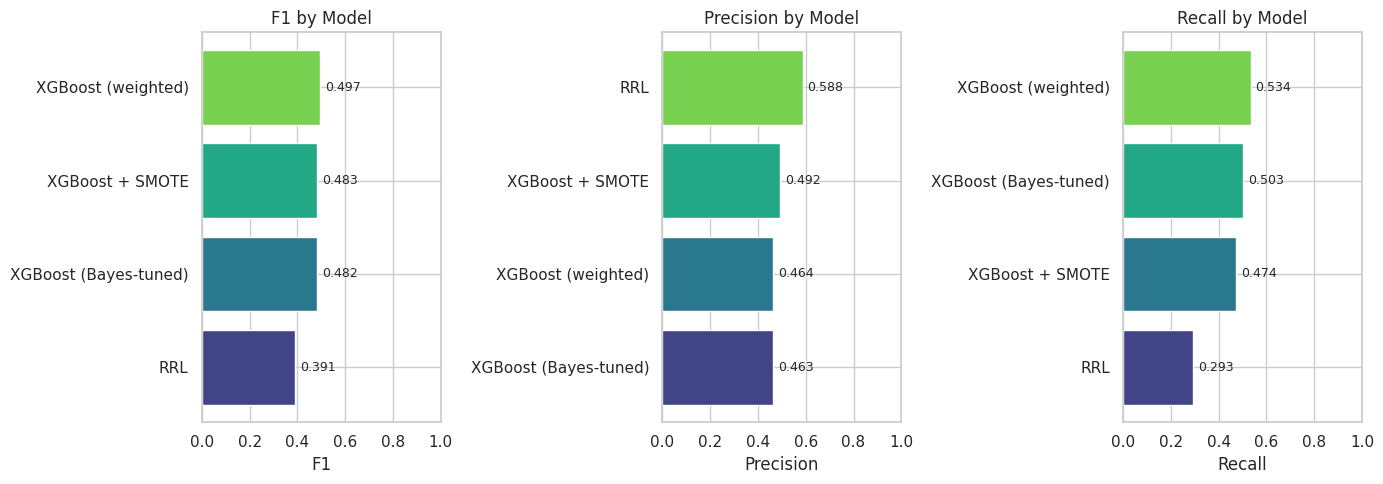

Saved: /home/ermaolaoye/data-mining/outputs/plots/model_comparison.png


In [29]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metrics_to_plot = ["f1", "precision", "recall"]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))

for ax, metric in zip(axes, metrics_to_plot):
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(sorted_df["name"], sorted_df[metric], color=colors)
    ax.set_xlabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} by Model")
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                f"{val:.3f}", va="center", fontsize=9)

plt.tight_layout()
comparison_plot_path = PLOTS_DIR / "model_comparison.png"
plt.savefig(comparison_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {comparison_plot_path}")

In [ ]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str, ax=None):
    """Plot a confusion matrix with annotations."""
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=ax,
        xticklabels=["No", "Yes"], yticklabels=["No", "Yes"]
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    return ax


# Plot confusion matrices for all models in a grid
n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    title = f"{result['name']}\n(thr={result['threshold']:.3f})"
    plot_confusion_matrix(y_test, result["predictions"], title, ax=axes[idx])

# Hide unused subplots
for idx in range(len(all_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
cm_plot_path = PLOTS_DIR / "confusion_matrices.png"
plt.savefig(cm_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {cm_plot_path}")

## Model Saving

In [ ]:
# Map model names to pipelines
pipelines = {
    "XGBoost (weighted)": xgb_weighted_pipeline,
    "XGBoost + SMOTE": xgb_smote_pipeline,
    "Random Forest + SMOTE": rf_smote_pipeline,
}

# Save all models with their metadata
for result in all_results:
    model_name = result["name"]
    safe_name = model_name.lower().replace(" ", "_").replace("+", "").replace("(", "").replace(")", "")
    
    # Skip RRL - it's already saved as a PyTorch model (.pth) earlier
    if model_name == "RRL":
        print(f"Skipped: {model_name} (already saved as {rrl_model_path})")
        continue
    
    pipeline = pipelines[model_name]
    
    # Handle wrapper objects vs sklearn pipelines
    if hasattr(pipeline, 'named_steps'):
        model_to_save = pipeline
    else:
        # For wrapper objects, save the components
        model_to_save = {
            "preprocessor": pipeline.preprocessor,
            "model": pipeline.model,
            "is_wrapper": True
        }
    
    model_data = {
        "pipeline": model_to_save,
        "threshold": result["threshold"],
        "metrics": {k: v for k, v in result.items() if k not in ["predictions", "probabilities"]},
    }
    
    model_path = MODELS_DIR / f"{safe_name}.pkl"
    joblib.dump(model_data, model_path)
    print(f"Saved: {model_path}")

print(f"\nBest model by F1 score: {best_model_name}")

NameError: name 'log_reg_pipeline' is not defined

## Generate Predictions

Export predictions from all models for analysis and comparison.

In [ ]:
# Compile predictions from all models
predictions_df = pd.DataFrame({"actual": y_test})

for result in all_results:
    safe_name = result["name"].lower().replace(" ", "_").replace("+", "_").replace("(", "").replace(")", "")
    predictions_df[f"{safe_name}_prob"] = result["probabilities"]
    predictions_df[f"{safe_name}_pred"] = result["predictions"]

# Save predictions
predictions_path = PREDICTIONS_DIR / "classification_predictions.csv"
predictions_df.to_csv(predictions_path, index=False)

print(f"Saved predictions: {predictions_path}")
print(f"Shape: {predictions_df.shape}")
print(f"\nColumns: {list(predictions_df.columns)}")

## Model Interpretability

Use SHAP (SHapley Additive exPlanations) to understand feature importance for the best tree-based model.

In [ ]:
# Select best tree-based model for SHAP analysis
tree_models = comparison_df[comparison_df["name"].str.contains("XGBoost|Random Forest")]
best_tree_model = tree_models.iloc[0]["name"]

pipeline_map = {
    "XGBoost (weighted)": xgb_weighted_pipeline,
    "XGBoost + SMOTE": xgb_smote_pipeline,
    "Random Forest + SMOTE": rf_smote_pipeline,
}

shap_pipeline = pipeline_map[best_tree_model]
print(f"Generating SHAP values for: {best_tree_model}")

# Get feature names and classifier based on pipeline type
if hasattr(shap_pipeline, 'named_steps'):
    # Standard sklearn pipeline
    feature_names = shap_pipeline.named_steps["preprocessor"].get_feature_names_out()
    X_test_transformed = shap_pipeline.named_steps["preprocessor"].transform(X_test)
    classifier = shap_pipeline.named_steps["classifier"]
else:
    # Wrapper object
    feature_names = shap_pipeline.preprocessor.get_feature_names_out()
    X_test_transformed = shap_pipeline.preprocessor.transform(X_test)
    classifier = shap_pipeline.model

# Sample for faster computation
sample_size = min(1000, X_test_transformed.shape[0])
sample_idx = np.random.RandomState(RANDOM_STATE).choice(
    X_test_transformed.shape[0], sample_size, replace=False
)
X_sample = X_test_transformed[sample_idx]

# Convert sparse matrix to dense if needed
if hasattr(X_sample, "toarray"):
    X_sample = X_sample.toarray()

# Create SHAP explainer and compute values
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_sample)

# Handle binary classification output format
# Some models return list [neg_class, pos_class], others return single array
if isinstance(shap_values, list):
    shap_values_display = shap_values[1]  # Use positive class
else:
    shap_values_display = shap_values

print(f"SHAP values shape: {shap_values_display.shape}")

In [ ]:
# Plot SHAP summary (bar chart)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_display,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False,
)
plt.title(f"Feature Importance - {best_tree_model}")
plt.tight_layout()
shap_bar_path = PLOTS_DIR / "shap_feature_importance.png"
plt.savefig(shap_bar_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {shap_bar_path}")

In [ ]:
# Plot SHAP summary (beeswarm - shows feature value impact)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_display,
    X_sample,
    feature_names=feature_names,
    max_display=15,
    show=False,
)
plt.title(f"SHAP Value Distribution - {best_tree_model}")
plt.tight_layout()
shap_beeswarm_path = PLOTS_DIR / "shap_beeswarm.png"
plt.savefig(shap_beeswarm_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {shap_beeswarm_path}")